In [1]:
import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np
from tensorflow.keras import Input, Model
tf.random.set_seed(221)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout

In [2]:
nqubits = 4
n_layers = 3
output_size = 3
batch_size = 32
l_r = 0.05
num_epochs = 20
dropout_thresh = 0.1
model_type = 0 # 0 for expected values as output and 1 for probability distribution as output of the quantum layer

In [3]:
num_features= 4
data = np.loadtxt("multiclass_classification/iris.csv", delimiter=",")
np.random.shuffle(data)
validation_split = 0.75
X = data[:, 0:num_features]
Y = data[:, -1].astype(int)

In [4]:
# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
num_train = int(validation_split * len(data))
index = np.random.permutation(range(len(data)))
X_train = X_norm[index[:num_train]]
Y_train = Y[index[:num_train]]
X_val = X_norm[index[num_train:]]
Y_val = Y[index[num_train:]]

In [5]:
# inputs = tf.constant(np.random.random((batches, nqubits)), dtype=tf.float32)
inputs = tf.constant(X_train, dtype=tf.float32)
# output_size is the number of classes
outputs = tf.one_hot(Y_train, depth=output_size)

inputs_test = tf.constant(X_val, dtype=tf.float32)
# output_size is the number of classes
outputs_test = tf.one_hot(Y_val, depth=output_size)

# define weight_shapes
weight_shapes = {"weights": (n_layers, nqubits, 3)}
ip = Input(shape=(1, num_features))

In [9]:
model = Sequential()
model.add(Dense(num_features, activation='tanh'))
model.add(Dropout(dropout_thresh))
model.add(Dense(6, activation='tanh'))
model.add(Dropout(dropout_thresh))
model.add(Dense(output_size, activation='softmax'))

In [11]:
%load_ext tensorboard
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(inputs, outputs, validation_data=(inputs_test,outputs_test), epochs=num_epochs, batch_size=batch_size, callbacks=[tensorboard_callback])
model.summary()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/20
1/4 [======>.......................] - ETA: 0s - loss: 1.1351 - accuracy: 0.2500WARNING:tensorflow:From /opt/anaconda3/envs/QML/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


4/4 [==============================] - 0s 37ms/step - loss: 1.0337 - accuracy: 0.4107 - val_loss: 0.8123 - val_accuracy: 0.6842
Epoch 2/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7619 - accuracy: 0.5982 - val_loss: 0.4883 - val_accuracy: 0.9474
Epoch 3/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5063 - accuracy: 0.7500 - val_loss: 0.5034 - val_accuracy: 0.6053
Epoch 4/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4242 - accuracy: 0.7679 - val_loss: 0.3632 - val_accuracy: 0.8684
Epoch 5/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4486 - accuracy: 0.7054 - val_loss: 0.4299 - val_accuracy: 0.6579
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4759 - accuracy: 0.7500 - val_loss: 0.4418 - val_accuracy: 0.6316
Epoch 7/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3866 - accuracy: 0.8393 - val_loss: 0.3057 - val_accuracy: 0.8421
Epoch 8/20
4/4 [============================

In [13]:
logdir

'logs/20201122-145402'

In [14]:
%tensorboard --logdir 'logs/20201122-145402'

In [16]:
preds = model.predict(inputs_test)
preds_class = np.argmax(preds, axis=1)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score
print(confusion_matrix(Y_val, preds_class))
print(classification_report(Y_val, preds_class))

[[12  0  0]
 [ 0  9  0]
 [ 0  3 14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.75      1.00      0.86         9
           2       1.00      0.82      0.90        17

    accuracy                           0.92        38
   macro avg       0.92      0.94      0.92        38
weighted avg       0.94      0.92      0.92        38



In [20]:
jaccard_score(Y_val, preds_class, average='weighted')

0.8618421052631579

In [21]:
costs_list = [1.033686399,0.761916459,0.506318629,0.424207538,0.448645592,0.47588256,0.38661024,0.352474988,0.405023754,0.282254636,0.30408892,0.286612034,0.381914914,0.270553261,0.236818582,0.242696479,0.148690313,0.164018616,0.137405276,0.164506838]
train_acc = [0.410714298,0.598214269,0.75,0.767857134,0.705357134,0.75,0.839285731,0.857142866,0.758928597,0.866071403,0.839285731,0.866071403,0.830357134,0.892857134,0.910714269,0.910714269,0.964285731,0.946428597,0.955357134,0.919642866]
test_acc = [0.684210539,0.947368443,0.605263174,0.868421078,0.657894731,0.631578922,0.842105269,0.605263174,0.868421078,0.631578922,0.868421078,0.815789461,0.921052635,1,0.868421078,0.973684192,0.894736826,0.947368443,1,0.921052635]

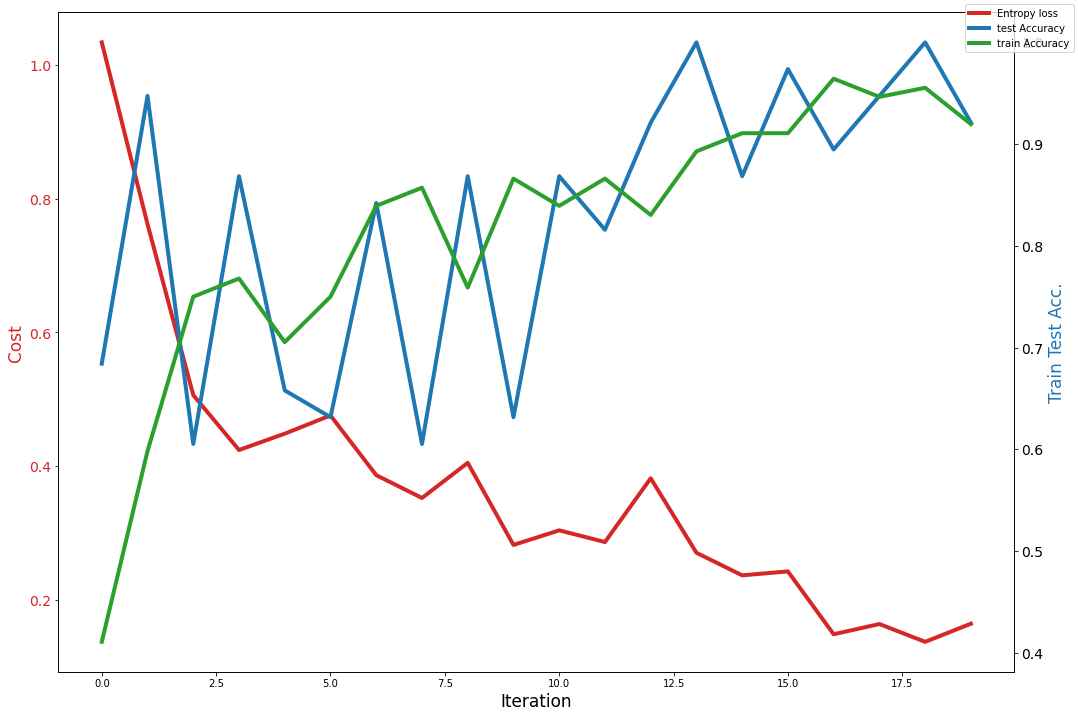

In [22]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 10))
iters = np.arange(0, num_epochs, 1)
colors = ["tab:red", "tab:blue", "tab:green"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs_list, color=colors[0], linewidth=4, label='Entropy loss')
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Train Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4, label='test Accuracy')
ax2.plot(iters, train_acc, color=colors[2], linewidth=4, label='train Accuracy')


ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

plt.grid(False)
plt.tight_layout()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)

fig.legend(lines, labels)
plt.show()